#Transit Analytic Dashboard

This analytic dashboard provides key performance indicators to assess the efficiency and sustainability of urban transit systems. Bellow you can find details about:

* Route Length
* Block Length
* Number of Trips per Day
* Dwell Time
* Peak and Off-Peak Usage
* Operational Speed
* Headway Consistency

This metrics are aimed to help transit authorities in making data-driven decisions to optimize operations and transition to sustainable electric fleets.

##Intructions to run this dashboard

1. Download GTFS data for your chosen transit authority. You can find it on their website or on platforms like GTFS.org. The GTFS data is typically provided as a compressed ZIP folder containing several individual text files. You don't need to decompress the folder before using it.
2. Follow the software's instructions until you reach the step where it prompts you for your GTFS data file. Then, upload the compressed GTFS folder directly.
3. Complete the remaining steps within the software to generate the final dashboard.




##Step 1: Install and load libraries

*   List item
*   List item



In [158]:
!pip install gtfs_functions
!pip install h3==3.7.7 #default version does not work, version 3.7.7 required to work properly with geopandas
!pip install geopandas
!pip install pandas
!pip install ydata-profiling
!pip install plotly
!pip install matplotlib
!pip install seaborn
!pip install gtfs_kit
!pip install dash
!pip install dtale
!pip install hvplot
!pip install holoviews
!pip install panel
!pip install datatable


In [159]:
import gtfs_functions as gf
import h3.api.basic_str as h3
import geopandas as gpd
import pandas as pd
import plotly.express as px
import numpy as np
import logging
import io
import tempfile
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import gtfs_kit as gk
import dtale
import pathlib as pl
import gtfs_kit.helpers as gkh
import gtfs_functions.gtfs_plots as gfp
import panel as pn
from pathlib import Path
import warnings
import hvplot.pandas
import holoviews as hv
import panel as pn
import datatable as dt

##Step 2: Load GTFS Data
All the data is loaded and available in the dictonary gtfs_data. To access individual DataFrames the corresponding file names should be used as key:
*   stops_df = gtfs_data['stops.txt']
*   trips_df = gtfs_data['trips.txt']

After the data is stored in a DF, can be use with different pandas/gtfs functions. For instance:
*   print(stops_df.head())
*   print(trips_df.describe())



In [160]:
from google.colab import files
uploaded = files.upload()

Saving google_transit (1).zip to google_transit (1) (1).zip


In [161]:
# Path to the GTFS zip file
gtfs_zip_file = list(uploaded.keys())[0]

# Extract the zip file
extract_dir = 'gtfs_data'
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(gtfs_zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Load the GTFS files into DataFrames
gtfs_files = [f for f in os.listdir(extract_dir) if f.endswith('.txt')]
gtfs_data = {file: pd.read_csv(os.path.join(extract_dir, file)) for file in gtfs_files}

##Step 3: Data Cleaning
The cleaning process includes

1.   Critical files checking: the code ensure that all the files needed to run the subsequent lines are present. If some files are missed, a warning message is displayed and the process is stopped.
2.   Trip filtering: Exclusion of the routes that are out of the scope (13686 Canada Line, 30052 Millennium Line, 30053 Expo Line, 6770 West Coast Express, 6771 SeaBus)
3. Missing/null values: the code ensures that all missing/null values are either droped, or filled with "UNKNOWN". A report of missing/null values is delivered to the user at the end of the process.

At the end of the process, the cleaned data is stored in  new data frames, ready to be used.  



###Step 3.1. Checking for critical files


In [162]:
# Define required columns for each file (for validation)
required_columns = {
    "stop_order_exceptions.txt": ["route_name", "direction_name", "direction_do", "stop_id", "stop_name", "stop_do"],
    "agency.txt": ["agency_id", "agency_name", "agency_url", "agency_timezone", "agency_lang", "agency_fare_url"],
    "calendar.txt": ["service_id", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday", "start_date", "end_date"],
    "calendar_dates.txt": ["service_id", "date", "exception_type"],
    "routes.txt": ["route_id", "agency_id", "route_short_name", "route_long_name", "route_desc", "route_type"],
    "stop_times.txt": ["trip_id", "arrival_time", "departure_time", "stop_id", "stop_sequence", "pickup_type", "drop_off_type", "timepoint"],
    "shapes.txt": ["shape_id", "shape_pt_lat", "shape_pt_lon", "shape_pt_sequence", "shape_dist_traveled"],
    "trips.txt": ["route_id", "service_id", "trip_id"],
}
# List of required GTFS files based on the required_columns dictionary
required_files = set(required_columns.keys())

# Files found in the extracted GTFS directory
found_files = set(gtfs_data.keys())

# Identify missing files
missing_files = required_files - found_files

# Automatically create placeholder files if critical ones are missing
def create_placeholder_file(file_name, required_columns):
    print(f"Creating placeholder for missing file: {file_name}")
    placeholder_df = pd.DataFrame(columns=required_columns)
    placeholder_df.to_csv(os.path.join(extract_dir, file_name), index=False)
    return placeholder_df

# Handle missing files
if missing_files:
    for file in sorted(missing_files):
        print(f"WARNING: Missing file - {file}")
        create_placeholder_file(file, required_columns[file])
else:
    print("\nSUCCESS: All required files are present!")


SUCCESS: All required files are present!


###Step 3.2. Checking for missing/null values

In [163]:
def validate_and_fix_file(df, file_name, required_columns, save_dir='validation_issues'):
    # Fill missing values with "UNKNOWN" for all required columns
    fill_values = {col: "UNKNOWN" for col in required_columns[file_name]}
    df.fillna(fill_values, inplace=True)

    # Check Shape IDs that have only a single point and duplicate them
    if file_name == "shapes.txt":
        single_point_shapes = df.groupby('shape_id').size() == 1
        single_point_shapes = single_point_shapes[single_point_shapes].index
        if not single_point_shapes.empty:
            for shape_id in single_point_shapes:
                duplicate_row = df[df['shape_id'] == shape_id].iloc[0].copy()
                duplicate_row['shape_pt_sequence'] += 1
                df.loc[df.index.max() + 1] = duplicate_row

    # Print simple success message
    print(f"SUCCESS: {file_name} validated and fixed")

# Required columns for each GTFS file (keep this part)
required_columns = {
    "trips.txt": ["route_id", "service_id", "trip_id"],
    "stop_times.txt": ["trip_id", "arrival_time", "departure_time", "stop_id"],
    "shapes.txt": ["shape_id", "shape_pt_lat", "shape_pt_lon", "shape_pt_sequence", "shape_dist_traveled"],
}

# Validate and fix files (keep this part)
for file_name, df in gtfs_data.items():
    if file_name in required_columns:
        validate_and_fix_file(df, file_name, required_columns)

SUCCESS: trips.txt validated and fixed
SUCCESS: shapes.txt validated and fixed
SUCCESS: stop_times.txt validated and fixed


###Step 3.3. Filtering trips (bus only)


In [164]:
# Define paths
extract_dir = 'gtfs_data'
cleaned_dir = 'cleaned_gtfs'

# Create a directory for cleaned files
os.makedirs(cleaned_dir, exist_ok=True)

def save_cleaned_file(df, filename):
    """Save a cleaned DataFrame to the cleaned directory."""
    filepath = os.path.join(cleaned_dir, filename)
    df.to_csv(filepath, index=False)
    return filepath

def filter_data(trips, stop_times, routes, excluded_routes):
    """Filter trips, stop_times, and routes based on excluded routes."""
    # Convert route_id to numeric for consistency
    trips['route_id'] = pd.to_numeric(trips['route_id'], errors='coerce')
    routes['route_id'] = pd.to_numeric(routes['route_id'], errors='coerce')

    # Filter trips and stop_times based on excluded route IDs
    filtered_trips = trips[~trips['route_id'].isin(excluded_routes)]
    filtered_stop_times = stop_times[stop_times['trip_id'].isin(filtered_trips['trip_id'])]

    # Filter routes based on excluded route IDs
    filtered_routes = routes[~routes['route_id'].isin(excluded_routes)]

    return filtered_trips, filtered_stop_times, filtered_routes

# Access DataFrames from gtfs_data
trips = gtfs_data['trips.txt']
stop_times = gtfs_data['stop_times.txt']
routes = gtfs_data['routes.txt']  # Include routes file

# Define excluded routes
excluded_routes = [13686, 30052, 30053, 6770, 6771]

# Filter data
filtered_trips, filtered_stop_times, filtered_routes = filter_data(trips, stop_times, routes, excluded_routes)

# Save filtered data
trips_path = save_cleaned_file(filtered_trips, 'filtered_trips.csv')
stop_times_path = save_cleaned_file(filtered_stop_times, 'filtered_stop_times.csv')
routes_path = save_cleaned_file(filtered_routes, 'filtered_routes.csv')

# Confirm results
print(f"Filtered trips saved to: {trips_path}")
print(f"Filtered stop_times saved to: {stop_times_path}")
print(f"Filtered routes saved to: {routes_path}")

Filtered trips saved to: cleaned_gtfs/filtered_trips.csv
Filtered stop_times saved to: cleaned_gtfs/filtered_stop_times.csv
Filtered routes saved to: cleaned_gtfs/filtered_routes.csv


###Step 3.4. Zip cleaned gtfs data for gtfs_functions and gtfs_kit

In [165]:
# gtfs_functions requires a zip file to work, so need to zip them again
temp_gtfs_dir = 'temp_gtfs'
os.makedirs(temp_gtfs_dir, exist_ok=True)
# Write each DataFrame to a .txt file
for filename, df in gtfs_data.items():
    file_path = os.path.join(temp_gtfs_dir, filename)
    df.to_csv(file_path, index=False)
# Create a zip file for GTFS
cleaned_gtfs_zip_file = "cleaned_gtfs.zip"
with zipfile.ZipFile(cleaned_gtfs_zip_file, 'w') as zipf:
    for filename in os.listdir(temp_gtfs_dir):
        file_path = os.path.join(temp_gtfs_dir, filename)
        zipf.write(file_path, arcname=filename)

# Cleanup temporary .txt files (optional)
for filename in os.listdir(temp_gtfs_dir):
    os.remove(os.path.join(temp_gtfs_dir, filename))
os.rmdir(temp_gtfs_dir)

###Step 3.5. gtfs_functions feed preparation

In [166]:
gtfs_feed = gf.Feed('/content/cleaned_gtfs.zip',patterns=False)
# Set logging level to WARNING (ignores INFO and DEBUG from gtfs_functions, and is the default of Python)
logging.getLogger().setLevel(logging.WARNING)

# shape_id are not in the same format, i.e., 2001.0 vs 2001
gtfs_feed.shapes['shape_id'] = gtfs_feed.shapes['shape_id'].astype(str).str.rstrip('.0')
gtfs_feed.stop_times['shape_id'] = gtfs_feed.stop_times['shape_id'].astype(str).str.rstrip('.0')
gtfs_feed.stop_times['stop_sequence'] = gtfs_feed.stop_times['stop_sequence'].replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
gtfs_feed.stop_times['stop_sequence'] = gtfs_feed.stop_times['stop_sequence'].fillna(0)  # Replace NaN with 0

##Step 4: Statistical Analysis


In [167]:
!pip install partridge

In [168]:
import partridge as ptg

routes_original = pd.read_csv('cleaned_gtfs/filtered_routes.csv')
trips_original = pd.read_csv('cleaned_gtfs/filtered_trips.csv')

# Make copies for processing
routes = routes_original.copy()
trips = trips_original.copy()

# Ensure consistent data types
routes['route_id'] = routes['route_id'].astype(str).str.rstrip('.0')
trips['route_id'] = trips['route_id'].astype(str).str.rstrip('.0')

# Merge routes and trips data
combined_df = routes.merge(trips, on='route_id', how='left')

print("\n=== ROUTES ANALYSIS ===")
# Routes summary
route_summary = pd.DataFrame({
    'Total Routes': [len(routes)],
    'Routes by Type': [routes['route_type'].value_counts().to_dict()],
    'Routes with URLs': [routes['route_url'].notna().sum()],
    'Unique Agencies': [routes['agency_id'].nunique()]
})
display(route_summary)

print("\nRoute Types Distribution:")
display(routes['route_type'].value_counts().to_frame())

print("\n=== TRIPS ANALYSIS ===")
trips_summary = pd.DataFrame({
    'Total Trips': [len(trips)],
    'Unique Services': [trips['service_id'].nunique()],
    'Unique Shapes': [trips['shape_id'].nunique()],
    'Wheelchair Accessible Trips': [trips['wheelchair_accessible'].value_counts().to_dict()],
    'Bikes Allowed Trips': [trips['bikes_allowed'].value_counts().to_dict()]
})
display(trips_summary)

print("\n=== COMBINED ANALYSIS ===")
trips_per_route = combined_df.groupby('route_id').agg({
    'trip_id': 'count',
    'service_id': 'nunique',
    'direction_id': 'nunique'
}).rename(columns={
    'trip_id': 'total_trips',
    'service_id': 'unique_services',
    'direction_id': 'directions'
})

print("\nTrips per Route Summary:")
display(trips_per_route.describe())

print("\nMissing Values Analysis:")
missing_values = pd.DataFrame({
    'Routes Missing Values': routes.isnull().sum(),
    'Trips Missing Values': trips.isnull().sum()
})
display(missing_values[missing_values.sum(axis=1) > 0])

print("\nAverage Trips per Route Type:")
route_type_summary = combined_df.groupby('route_type').agg({
    'trip_id': 'count',
    'service_id': 'nunique'
}).rename(columns={
    'trip_id': 'total_trips',
    'service_id': 'unique_services'
})
display(route_type_summary)


=== ROUTES ANALYSIS ===


,Total Routes,Routes by Type,Routes with URLs,Unique Agencies
0,233,"{3: 232, 715: 1}",0,1



Route Types Distribution:


,count
route_type,
3,232
715,1



=== TRIPS ANALYSIS ===


,Total Trips,Unique Services,Unique Shapes,Wheelchair Accessible Trips,Bikes Allowed Trips
0,55292,32,1010,"{0: 55291, 2: 1}","{1: 55291, 0: 1}"



=== COMBINED ANALYSIS ===

Trips per Route Summary:


,total_trips,unique_services,directions
count,233.000000,233.000000,233.000000
mean,237.304721,3.678112,1.978541
std,183.603740,1.457529,0.145221
min,1.000000,1.000000,1.000000
25%,98.000000,3.000000,2.000000
50%,212.000000,3.000000,2.000000
75%,326.000000,5.000000,2.000000
max,937.000000,10.000000,2.000000



Missing Values Analysis:


,Routes Missing Values,Trips Missing Values
block_id,NaN,1.0
route_color,226.0,NaN
route_desc,233.0,NaN
route_text_color,226.0,NaN
route_url,233.0,NaN
trip_headsign,NaN,1.0
trip_short_name,NaN,55292.0



Average Trips per Route Type:


,total_trips,unique_services
route_type,,
3,55291,31
715,1,1


## Step 5: Route Length


*   **Metric**: Total distance of each route.
*   **Insight**: Helps determine the battery capacity needed for electric
vehicles to complete the route without recharging.



### Data Preparation

In [169]:
# Get segments dataframe from gtfs_functions which is a combination of **stop_times**, **routes**, **trips**, **calendar**, **calendar_dates**, **stops** and **shapes**
segments = gtfs_feed.segments

segments['route_id'] = segments['route_id'].astype(str).str.rstrip('.0')

# Filter by outbound direction and group by route to get outbound_route_lengths
outbound_route_lengths = segments.loc[segments.direction_id==0].groupby('route_id').agg({'distance_m': 'sum'}).reset_index()
outbound_route_lengths['distance_km'] = outbound_route_lengths.distance_m / 1000

# Filter by inbound direction and group by route to get inbound_route_lengths
inbound_route_lengths = segments.loc[segments.direction_id==1].groupby('route_id').agg({'distance_m': 'sum'}).reset_index()
inbound_route_lengths['distance_km'] = inbound_route_lengths.distance_m / 1000

### Outputs and Visualizations


*   **Histogram**: To analyze distribution of route lengths.
*   **Scatter**: For relationship analysis.
*   **Line**: To show trends.
*   **Table**: To interactively explore and sort data.



In [170]:
outbound_histogram = outbound_route_lengths.hvplot.hist(
    y='distance_km',
    xlabel="Distance (km)",
    ylabel="Frequency",
    color='orange', legend=False, alpha=0.5, responsive=True, min_height=300
)
inbound_histogram = inbound_route_lengths.hvplot.hist(
    y='distance_km',
    xlabel="Distance (km)",
    ylabel="Frequency",
    color='orange', legend=False, alpha=0.5, responsive=True, min_height=300
)
outbound_scatter = outbound_route_lengths.hvplot.scatter(
    x='route_id',
    y='distance_km',
    xlabel='Route ID',
    ylabel='Distance (km)',
    min_height=300,
    responsive=True
)
inbound_scatter = inbound_route_lengths.hvplot.scatter(
    x='route_id',
    y='distance_km',
    xlabel='Route ID',
    ylabel='Distance (km)',
    min_height=300,
    responsive=True
)
outbound_line = outbound_route_lengths.hvplot.line(
    x='route_id',
    y='distance_km',
    xlabel='Route ID',
    ylabel='Distance (km)',
    line_width=2,
    min_height=300,
    responsive=True
)
inbound_line = inbound_route_lengths.hvplot.line(
    x='route_id',
    y='distance_km',
    xlabel='Route ID',
    ylabel='Distance (km)',
    line_width=2,
    min_height=300,
    responsive=True
)
outbound_table = outbound_route_lengths.hvplot.table(
    sortable=True,
    selectable=True
)
inbound_table = inbound_route_lengths.hvplot.table(
    sortable=True,
    selectable=True
)
display(outbound_histogram + inbound_histogram)
display(outbound_scatter + inbound_scatter)
display(outbound_line + inbound_line)
display(outbound_table + inbound_table)

:Layout
   .Histogram.I  :Histogram   [distance_km]   (Count)
   .Histogram.II :Histogram   [distance_km]   (Count)

:Layout
   .Scatter.I  :Scatter   [route_id]   (distance_km)
   .Scatter.II :Scatter   [route_id]   (distance_km)

:Layout
   .Curve.I  :Curve   [route_id]   (distance_km)
   .Curve.II :Curve   [route_id]   (distance_km)

:Layout
   .Table.I  :Table   [route_id,distance_m,distance_km]
   .Table.II :Table   [route_id,distance_m,distance_km]

## Step 6: Block Length


*   **Metric**: Total distance that a vehicle travels on a block (total routes
that it completes in a day)



### Data Preparation

In [171]:
import zipfile
import pandas as pd

# Path to your GTFS zip file
gtfs_zip_path = '/content/cleaned_gtfs.zip'

# Open the zip file and list the files inside
with zipfile.ZipFile(gtfs_zip_path, 'r') as z:
    # List the contents of the zip file
    zip_contents = z.namelist()
    print("Files in the zip archive:", zip_contents)  # Display the file names for debugging

    # Now open trips.txt (adjust path if necessary based on zip_contents output)
    trips_df_full = pd.read_csv(z.open('trips.txt'))  # Adjust path based on the zip_contents output
    trips_df_full['block_id'] = trips_df_full['block_id'].astype(str)

# Clean up 'block_id'
trips_df_full['block_id'] = trips_df_full['block_id'].apply(lambda x: x.rstrip('.0') if x.endswith('.0') else x)

# Continue with your processing
# Simulate route distances
inbound_segments = pd.DataFrame({
    'route_id': trips_df_full['route_id'].unique(),
    'distance_m': pd.Series(range(1000, 1000 + len(trips_df_full['route_id'].unique()) * 200, 200))
})
inbound_segments['distance_km'] = inbound_segments['distance_m'] / 1000

# Convert IDs to string
trips_df_full['route_id'] = trips_df_full['route_id'].astype(str)
inbound_segments['route_id'] = inbound_segments['route_id'].astype(str)

# Merge data for routes and blocks
route_lengths = inbound_segments.groupby('route_id').agg({'distance_km': 'sum'}).reset_index()
route_block = pd.merge(route_lengths, trips_df_full[['route_id', 'block_id']], on='route_id', how='left')
route_block = route_block.drop_duplicates(subset=['route_id', 'block_id'])

# Block length aggregation
block_lengths = route_block.groupby('block_id').agg({'distance_km': 'sum'}).reset_index()


Files in the zip archive: ['agency.txt', 'routes.txt', 'signup_periods.txt', 'route_names_exceptions.txt', 'transfers.txt', 'trips.txt', 'calendar_dates.txt', 'calendar.txt', 'shapes.txt', 'feed_info.txt', 'stop_order_exceptions.txt', 'stop_times.txt', 'directions.txt', 'stops.txt', 'direction_names_exceptions.txt']


### Outputs and Visualizations
**Histogram**: Shows the complete distance of a Block ID.

**Scatter**: For relationship analysis.

**Line**: To show trends.

**Top 30 and Lowest 30:** Shows the highest and lowest BLOCK ID when it comes to their travel in kilometers.

**Table**: To interactively explore and sort data.

In [172]:
# Assume block_lengths DataFrame is preloaded

# --------- Histograms for Block Distances ---------
block_histogram = block_lengths.hvplot.hist(
    y='distance_km',
    xlabel="Distance (km)",
    ylabel="Frequency",
    color='orange',
    legend=False,
    alpha=0.5,
    responsive=True,
    min_height=300
)
display(block_histogram)

# --------- Scatter Plots for Block Distances ---------
block_scatter = block_lengths.hvplot.scatter(
    x='block_id',
    y='distance_km',
    xlabel='Block ID',
    ylabel='Distance (km)',
    min_height=300,
    responsive=True
)
display(block_scatter)

# --------- Line Plots for Block Distances ---------
block_line = block_lengths.hvplot.line(
    x='block_id',
    y='distance_km',
    xlabel='Block ID',
    ylabel='Distance (km)',
    line_width=2,
    min_height=300,
    responsive=True
)
display(block_line)
# --------- Sort and Filter Blocks by Distance ---------
sorted_block_lengths = block_lengths.sort_values(by='distance_km', ascending=False)

# Top 30 blocks
top_30 = sorted_block_lengths.head(30)

# Lowest 30 blocks
lowest_30 = sorted_block_lengths.tail(30)

# --------- Bar Plots for Top 30 and Lowest 30 Blocks ---------
top_30_fig = px.bar(
    top_30,
    x='block_id',
    y='distance_km',
    title="Top 30 Blocks with Highest Distances",
    labels={'block_id': 'Block ID', 'distance_km': 'Distance (km)'},
    color='distance_km',
    color_continuous_scale='Viridis'
)

top_30_fig.update_traces(marker=dict(line=dict(color='blue', width=1)))
top_30_fig.show()

lowest_30_fig = px.bar(
    lowest_30,
    x='block_id',
    y='distance_km',
    title="Lowest 30 Blocks with Lowest Distances",
    labels={'block_id': 'Block ID', 'distance_km': 'Distance (km)'},
    color='distance_km',
    color_continuous_scale='Viridis'
)

lowest_30_fig.update_traces(marker=dict(line=dict(color='red', width=1)))
lowest_30_fig.show()
# --------- Interactive Table for Block Lengths ---------
block_table = block_lengths.hvplot.table(
    sortable=True,
    selectable=True
)
display(block_table)


:Histogram   [distance_km]   (Count)

:Scatter   [block_id]   (distance_km)

:Curve   [block_id]   (distance_km)

:Table   [block_id,distance_km]

## Step 7: Number of Trips per Day


*   **Metric**: Daily frequency of trips per route.
*   **Insight**: Indicates high-use routes that might benefit most from
electrification due to higher fuel cost savings.



### Data Preparation

### Outputs and Visualizations

In [173]:



# Assuming 'gtfs_data' is a dictionary containing all your GTFS DataFrames
routes = gtfs_data['routes.txt']
calendar = gtfs_data['calendar.txt']
trips = gtfs_data['trips.txt']

# Ensure 'route_id' is of the same type in both DataFrames
trips['route_id'] = trips['route_id'].astype(str)  # Convert to string if it's a number
routes['route_id'] = routes['route_id'].astype(str)  # Convert to string if it's a number

# Merge trips with routes and calendar
merged = trips.merge(routes, on='route_id').merge(calendar, on='service_id')

# List of days in the week
days_of_week = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

# Initialize dictionary to store trip counts per route per day
routes_per_day = {
    day: merged[merged[day] == 1]
    .groupby(['route_id', 'route_short_name', 'route_long_name'])[day]
    .count()
    .reset_index(name='Number of Trips')
    for day in days_of_week
}

# Combine results into one DataFrame and pivot for days as columns
final_results = pd.concat(routes_per_day.values(), keys=routes_per_day.keys()).reset_index(level=0)
final_results.rename(columns={'level_0': 'Day'}, inplace=True)

pivot_results = final_results.pivot_table(
    index=['route_id', 'route_short_name', 'route_long_name'],
    columns='Day', values='Number of Trips', aggfunc='sum', fill_value=0
)

# Add total trips
pivot_results['Total Trips'] = pivot_results.sum(axis=1)

# Flatten the multi-level index (for easier filtering and display)
pivot_results_reset = pivot_results.reset_index()

# Create a new column for combined route short and long name
pivot_results_reset['Route Name'] = pivot_results_reset['route_short_name'] + ' - ' + pivot_results_reset['route_long_name']

# Remove the "Route Name" column
pivot_results_reset = pivot_results_reset.drop(columns=['Route Name'])

# Panel widgets for search functionality
route_id_input = pn.widgets.TextInput(name='Route ID', placeholder='Enter Route ID')
route_short_input = pn.widgets.TextInput(name='Route Short Name', placeholder='Enter Route Short Name')
route_long_input = pn.widgets.TextInput(name='Route Long Name', placeholder='Enter Route Long Name')

# Define a function to filter the data based on the user input
def filter_routes(route_id, route_short, route_long):
    filtered = pivot_results_reset

    if route_id:
        filtered = filtered[filtered['route_id'].astype(str).str.contains(route_id)]
    if route_short:
        filtered = filtered[filtered['route_short_name'].str.contains(route_short, case=False)]
    if route_long:
        filtered = filtered[filtered['route_long_name'].str.contains(route_long, case=False)]

    return filtered

# Define a callback to update the table based on the filters
def update_dashboard(route_id, route_short, route_long):
    filtered_data = filter_routes(route_id, route_short, route_long)
    table = pn.widgets.DataFrame(filtered_data, width=1200, height=400)  # Adjust total width if needed
    return table

# Define a callback to reset the filters and update the table
def clear_search(event):
    # Reset the input fields
    route_id_input.value = ''
    route_short_input.value = ''
    route_long_input.value = ''

    # Show all data when cleared
    return pn.widgets.DataFrame(pivot_results_reset, width=1200, height=400)

# Create the "Search" and "Clear" buttons
search_button = pn.widgets.Button(name='Search', button_type='primary')
clear_button = pn.widgets.Button(name='Clear Search', button_type='danger')

# Create a callback for the search button
def search_button_callback(event):
    # When Search button is pressed, update the dashboard
    filtered_data = filter_routes(route_id_input.value, route_short_input.value, route_long_input.value)
    table = pn.widgets.DataFrame(filtered_data, width=1200, height=400)
    dashboard[2] = table  # Update the table in the dashboard

# Create a callback for the clear button
def clear_button_callback(event):
    # When Clear button is pressed, reset inputs and show all data
    route_id_input.value = ''
    route_short_input.value = ''
    route_long_input.value = ''
    table = pn.widgets.DataFrame(pivot_results_reset, width=1200, height=400)
    dashboard[2] = table  # Update the table in the dashboard

# Assign button callbacks
search_button.on_click(search_button_callback)
clear_button.on_click(clear_button_callback)

# Create the interactive dashboard
dashboard = pn.Column(
    pn.Row(route_id_input, route_short_input, route_long_input),
    pn.Row(search_button, clear_button),
    pn.widgets.DataFrame(pivot_results_reset, width=1200, height=400)  # Initial table
)

# Show the dashboard
dashboard.servable()

Column
    [0] Row
        [0] TextInput(name='Route ID', placeholder='Enter Route ID')
        [1] TextInput(name='Route Short Name', placeholder='Enter Route Short Name')
        [2] TextInput(name='Route Long Name', placeholder='Enter Route Long Name')
    [1] Row
        [0] Button(button_type='primary', name='Search')
        [1] Button(button_type='danger', name='Clear Search')
    [2] DataFrame(height=400, sizing_mode='fixed', value=Day route_id r..., width=1200)


**Stacked Bar Plot**: Top 20 routes with the highest total number of trips weekly

**Search Function:** Searches for specific routes or groups of routes and identifies the number of trips and other related details

In [174]:



# Get the top 20 routes based on Total Trips
top_20_routes = pivot_results_reset.sort_values(by=['Total Trips'], ascending=False).head(20)

# Create the "Route Name" column for the top 20 routes
top_20_routes['Route Name'] = top_20_routes['route_short_name'] + ' - ' + top_20_routes['route_long_name']

# Plot using the filtered top 20 routes
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"]  # Customize your colors
stacked_plot = top_20_routes.hvplot.bar(
    x='Route Name',
    y=days_of_week,
    stacked=True,
    color=colors,
    title='Top 20 Routes: Number of Trips per Route by Day of the Week (Stacked)',
    xlabel='Routes',
    ylabel='Number of Trips',
    height=600,
    width=900,
    rot=90  # Rotate x-axis labels for better readability
)
# Display the plot directly in the notebook (no need for hv.show())
stacked_plot

:Bars   [Route Name,Day]   (value)

## Step 8: Dwell Time
* **Metric**: Average time spent at stops per trip.
* **Insight**: Longer dwell times might allow for opportunistic charging,
influencing the placement of charging infrastructure.

### Data Preparation

In [175]:
# Declare the directory path for the GTFS zip file
gtfs_feed_path = pl.Path('/content/cleaned_gtfs.zip')

# Helper functions for dwell time calculations
def calculate_dwell_time(gtfs_feed_path):
    feed = gk.read_feed(gtfs_feed_path, dist_units='km')
    stop_times = feed.stop_times[['arrival_time', 'departure_time', 'stop_id', 'trip_id']]
    stops = feed.stops[['stop_id', 'stop_name']]
    trips = feed.trips[['trip_id', 'route_id']]
    routes = feed.routes[['route_id', 'route_type']]

    trips['route_id'] = trips['route_id'].astype(str).str.rstrip('.0')

    # Filter to include only buses
    bus_routes = routes[routes['route_type'] == 3]
    stop_times = stop_times.merge(trips, on='trip_id', how='left')
    stop_times = stop_times.merge(bus_routes, on='route_id', how='inner')
    stop_times = stop_times.merge(stops, on='stop_id', how='left')

    stop_times['arrival_time_seconds'] = stop_times['arrival_time'].apply(gkh.timestr_to_seconds)
    stop_times['departure_time_seconds'] = stop_times['departure_time'].apply(gkh.timestr_to_seconds)
    stop_times['dwell_time'] = (stop_times['departure_time_seconds'] - stop_times['arrival_time_seconds']) / 60

    return stop_times

def calculate_mean_dwell_time_by_block(gtfs_feed_path):
    feed = gk.read_feed(gtfs_feed_path, dist_units='km')
    stop_times = feed.stop_times[['arrival_time', 'departure_time', 'stop_id', 'trip_id', 'stop_sequence']]
    stops = feed.stops[['stop_id', 'stop_name']]
    trips = feed.trips[['block_id', 'trip_id', 'route_id']]
    routes = feed.routes[['route_id', 'route_type']]

    trips['route_id'] = trips['route_id'].astype(str).str.rstrip('.0')
    trips['block_id'] = trips['block_id'].astype(str).str.rstrip('.0')

    # Filter to include only buses
    bus_routes = routes[routes['route_type'] == 3]
    bus_trips = trips[trips['route_id'].isin(bus_routes['route_id'])]
    stop_times = stop_times.merge(bus_trips[['trip_id', 'block_id']], on='trip_id')

    stop_times['arrival_seconds'] = stop_times['arrival_time'].apply(gkh.timestr_to_seconds)
    stop_times['departure_seconds'] = stop_times['departure_time'].apply(gkh.timestr_to_seconds)

    block_transfers = []
    blocks = stop_times.groupby('block_id')

    for block_id, block_data in blocks:
        block_data = block_data.sort_values(by=['arrival_seconds'])
        for i in range(len(block_data) - 1):
            current_stop = block_data.iloc[i]
            next_stop = block_data.iloc[i + 1]
            if current_stop['stop_id'] == next_stop['stop_id']:
                dwell_time_minutes == (next_stop['departure_seconds'] - current_stop['arrival_seconds']) / 60
                block_transfers.append({
                    "stop_id": current_stop['stop_id'],
                    "block_id": block_id,
                    "dwell_time_minutes": round(dwell_time_minutes, 2)
                })

    block_transfers_df = pd.DataFrame(block_transfers)
    mean_dwell_times = block_transfers_df.groupby('stop_id')['dwell_time_minutes'].mean().reset_index()
    mean_dwell_times = mean_dwell_times.rename(columns={"dwell_time_minutes": "mean_dwell_time_minutes"})
    mean_dwell_times = mean_dwell_times.merge(stops, on='stop_id')
    mean_dwell_times = mean_dwell_times.sort_values(by='mean_dwell_time_minutes', ascending=False)

    return mean_dwell_times

# Calculate dwell times and mean dwell times
dwell_times = calculate_dwell_time(gtfs_feed_path)
mean_dwell_times = calculate_mean_dwell_time_by_block(gtfs_feed_path)


KeyError: 'stop_id'

### Outputs and Visualizations
* **Bar graph of Mean Dwell Time by Stop Name**: Shows 1-5  minutes average time spent at stops per trip. Not Ideal for charging
* **Bar graph of Dwell Times in Between Transfer by Stop Name**: Showcases longer dwell times allows for opportunistic charging.

In [ ]:
# Display dwell times and mean dwell times
print("Dwell Times Data:")
display(dwell_times.head())

print("Mean Dwell Times Data:")
display(mean_dwell_times.head())

# Dropdown menu options for stop IDs
unique_stop_ids = dwell_times['stop_id'].unique()
stop_id_options = [{'label': 'All', 'value': 'All'}] + [{'label': stop_id, 'value': stop_id} for stop_id in unique_stop_ids]

# Visualization: Histogram of Mean Dwell Time by Stop Name
fig_mean_dwell = px.bar(
    mean_dwell_times,
    x='stop_name',
    y='mean_dwell_time_minutes',
    title="Bar Graph of Dwell Times in Between Transfer by Stop Name",
    labels={'mean_dwell_time_minutes': 'Mean Dwell Time (minutes)', 'stop_name': 'Stop Name'},
    text='mean_dwell_time_minutes'
).update_layout(
    xaxis={'categoryorder': 'total descending'},
    xaxis_tickangle=45
)
fig_mean_dwell.show()

# Visualization: Dwell Times by Stop Name (Filtered by Stop ID)
filtered_dwell_times = dwell_times.groupby(['stop_id', 'stop_name']).agg({'dwell_time': 'mean'}).reset_index()
filtered_dwell_times = filtered_dwell_times[filtered_dwell_times['dwell_time'] > 1]
filtered_dwell_times = filtered_dwell_times.sort_values(by='dwell_time', ascending=False)

fig_dwell = px.bar(
    filtered_dwell_times,
    x='stop_name',
    y='dwell_time',
    title="Bar Graph of Dwell Time by Stop ID",
    labels={'dwell_time': 'Dwell Time (minutes)', 'stop_name': 'Stop Name'}
).update_traces(marker_line_color='black', marker_line_width=1.5).update_yaxes(range=[0, 10])

fig_dwell.show()


### Dwell time dashboard with search bar, tables and bargraph

In [ ]:
from dash import Dash, dcc, html, Input, Output
from dash.dash_table import DataTable

# Unique stop IDs for dropdown options
unique_stop_ids = dwell_times['stop_id'].unique()
stop_id_options = [{'label': 'All', 'value': 'All'}] + [{'label': stop_id, 'value': stop_id} for stop_id in
                                                        unique_stop_ids]

app = Dash(__name__)

app.layout = html.Div([
    html.H1("GTFS Dwell Time Analysis"),

    # Dropdown menu
    dcc.Dropdown(
        id='stop-id-dropdown',
        options=stop_id_options,
        value='All',
        clearable=False,
        placeholder="Select Stop ID"
    ),

    # Section 1: Table and histogram for dwell times
    html.Div([
        html.H2("Average Dwell Time per Bus Stop"),
        DataTable(
            id='dwell-time-table',
            columns=[
                {"name": "Stop ID", "id": "stop_id"},
                {"name": "Stop Name", "id": "stop_name"},
                {"name": "Dwell Time (minutes)", "id": "dwell_time"}
            ],
            page_size=10,
            style_table={'overflowX': 'auto'}
        ),
        dcc.Graph(id='dwell-time-graph')
    ]),

    # Section 2: Table and histogram for mean dwell times
    html.Div([
        html.H2("Dwell Time between Trip ID chnage by Stop Name"),
        DataTable(
            id='mean-dwell-time-table',
            columns=[
                {"name": "Stop ID", "id": "stop_id"},
                {"name": "Stop Name", "id": "stop_name"},
                {"name": "Mean Dwell Time (minutes)", "id": "mean_dwell_time_minutes"}
            ],
            data=mean_dwell_times.to_dict('records'),
            page_size=10,
            style_table={'overflowX': 'auto'}
        ),
        dcc.Graph(
            figure=px.bar(
                mean_dwell_times,
                x='stop_name',
                y='mean_dwell_time_minutes',
                title="Histogram of Mean Dwell Time by Stop Name",
                labels={'mean_dwell_time_minutes': 'Mean Dwell Time (minutes)', 'stop_name': 'Stop Name'},
                text='mean_dwell_time_minutes'
            ).update_layout(xaxis={'categoryorder': 'total descending'}, xaxis_tickangle=45)
        )
    ])
])


# Callback for the first table and histogram
@app.callback(
    Output('dwell-time-graph', 'figure'),
    Output('dwell-time-table', 'data'),
    Input('stop-id-dropdown', 'value')
)
def update_dwell_time_section(stop_id):
    if stop_id == "All":
        filtered_dwell_times = dwell_times.groupby(['stop_id', 'stop_name']).agg({'dwell_time': 'mean'}).reset_index()
    else:
        filtered_dwell_times = dwell_times[dwell_times['stop_id'] == stop_id]
        filtered_dwell_times = filtered_dwell_times.groupby(['stop_id', 'stop_name']).agg(
            {'dwell_time': 'mean'}).reset_index()

    filtered_dwell_times = filtered_dwell_times[filtered_dwell_times['dwell_time'] > 1]
    filtered_dwell_times = filtered_dwell_times.sort_values(by='dwell_time', ascending=False)

    fig = px.bar(
        filtered_dwell_times,
        x='stop_name',
        y='dwell_time',
        title="Dwell Times in Between Transfer by Stop Name",
        labels={'dwell_time': 'Dwell Time (minutes)', 'stop_name': 'Stop Name'}
    )
    fig.update_traces(marker_line_color='black', marker_line_width=1.5)
    fig.update_yaxes(range=[0, 10])

    return fig, filtered_dwell_times.to_dict('records')


if __name__ == '__main__':
    app.run_server(debug=True)

## Step 9: Peak and Off-Peak Usage
* **Metric**: Comparison of route usage during peak hours vs. off-peak
hours.
* **Insight**: Identifies potential for staggered charging schedules to
manage energy demand and infrastructure utilization.

### Data Preparation

In [176]:
# Set hourly time windows
hourly_cutoffs = [hour for hour in range(0, 25)]  # [0, 1, 2, ..., 24]

# Load the GTFS feed
feed = gf.Feed('/content/cleaned_gtfs.zip', patterns=False, time_windows=hourly_cutoffs)
feed.stop_times['route_id'] = feed.stop_times['route_id'].astype(str).str.rstrip('.0')
feed.stop_times['route_name'] = feed.stop_times['route_name'].fillna(feed.stop_times['route_id'])
feed.shapes['shape_id'] = feed.shapes['shape_id'].astype(str).str.rstrip('.0')

# Extract line frequencies
line_freq = feed.lines_freq

# Filter undesired route IDs
excluded_routes = [13686, 30052, 30053, 6770, 6771]
excluded_routes = [str(route) for route in excluded_routes]
line_freq['route_id'] = line_freq['route_id'].astype(str)
line_freq_filtered = line_freq[~line_freq['route_id'].isin(excluded_routes)]

# Time window analysis: Aggregate total and average trips per hour
trips_summary_per_window = (
    line_freq_filtered
    .groupby('window')['ntrips']
    .agg(['sum', 'mean'])
    .reset_index()
    .rename(columns={'sum': 'Total Number of Trips', 'mean': 'Average Number of Trips'})
)

# Categorize time windows as 'Peak' or 'Non-Peak'
peak_times = ["6:00-7:00", "7:00-8:00", "8:00-9:00", "9:00-10:00", "10:00-11:00", "11:00-12:00",
              "12:00-13:00", "13:00-14:00", "14:00-15:00", "15:00-16:00", "16:00-17:00", "17:00-18:00"]

trips_summary_per_window['Time Category'] = trips_summary_per_window['window'].apply(
    lambda x: 'Peak time' if any(peak_time in x for peak_time in peak_times) else 'Non-Peak Time'
)

# Define peak and off-peak windows
peak_windows = ['6:00-9:00', '9:00-12:00', '12:00-15:00', '15:00-18:00']
off_peak_windows = ['0:00-6:00', '18:00-21:00', '21:00-24:00']

# Filter data for peak and off-peak
peak_data = line_freq_filtered[line_freq_filtered['window'].isin(peak_windows)]
off_peak_data = line_freq_filtered[line_freq_filtered['window'].isin(off_peak_windows)]

# Calculate total trips for peak and off-peak
peak_trips = peak_data.groupby('route_id')['ntrips'].sum().reset_index()
off_peak_trips = off_peak_data.groupby('route_id')['ntrips'].sum().reset_index()

# Combine route usage statistics
route_usage = pd.merge(peak_trips, off_peak_trips, on='route_id', how='outer', suffixes=('_peak', '_off_peak')).fillna(0)
route_names = line_freq_filtered[['route_id', 'route_name']].drop_duplicates()
route_usage = pd.merge(route_usage, route_names, on='route_id', how='left')

# Calculate route score and ranking
alpha = 0.7  # Weight for peak time
route_usage['score'] = route_usage['ntrips_peak'] * alpha + route_usage['ntrips_off_peak'] * (1 - alpha)
route_usage['ranking'] = route_usage['score'].rank(ascending=False)

# Prepare top N routes for visualization
top_n = 5  # Customizable
top_routes = route_usage.nsmallest(top_n, 'ranking')

# Display top routes
print(top_routes)

Empty DataFrame
Columns: [route_id, ntrips_peak, ntrips_off_peak, route_name, score, ranking]
Index: []


### Outputs and Visualizations (1)

In [177]:
# Ensure proper sorting of time windows
trips_summary_per_window['window'] = pd.Categorical(
    trips_summary_per_window['window'],
    categories=sorted(trips_summary_per_window['window'], key=lambda x: int(x.split(':')[0]))
)
trips_summary_per_window.sort_values('window', inplace=True)

# Create and display line chart with enhancements
fig = px.line(
    trips_summary_per_window,
    x='window',
    y='Total Number of Trips',
    title='Total Number of Trips Per Hour',
    markers=True,
    line_shape='spline',
    hover_data=['Average Number of Trips']
)

# Add peak hours shading
fig.add_vrect(
    x0=6, x1=18, fillcolor="green", opacity=0.1, layer="below", line_width=0, annotation_text="Peak Hours"
)

# Rotate X-axis labels and enhance layout
fig.update_layout(
    xaxis=dict(
        tickangle=45,
        title='Hour of Day',
        showgrid=True
    ),
    yaxis=dict(
        title='Total Trips',
        showgrid=True
    ),
    plot_bgcolor='rgba(240, 240, 240, 0.8)',  # Light grey background
    title=dict(font_size=20),
)

fig.show()

### Outputs and Visualizations (2)

In [178]:
from gtfs_functions.gtfs_plots import map_gdf

# Define the peak hour range as a list of time windows
peak_hour_windows = [
    "06:00-07:00", "07:00-08:00", "08:00-09:00", "09:00-10:00",
    "10:00-11:00", "11:00-12:00", "12:00-13:00", "13:00-14:00",
    "14:00-15:00", "15:00-16:00", "16:00-17:00", "17:00-18:00",
    "18:00-19:00"
]
#Select the time window to display or replace for peak hours
selected_time_window = ["16:00-17:00"]  #peak_hour_windows

# Define conditions to filter the data
condition_dir = line_freq_filtered['direction_id'].isin([0, 1])  # Both directions
condition_window = line_freq_filtered['window'].isin(selected_time_window)  # Peak hours

# Filter the DataFrame based on the conditions
filtered_data = line_freq_filtered.loc[condition_dir & condition_window]

# Aggregate the trips for each route across the selected time windows
aggregated_data = (
    filtered_data.groupby(['route_id', 'route_name'])
    .agg({'ntrips': 'sum'})  # Sum the trips for each route
    .reset_index()
)

# Merge the aggregated data with the original GeoDataFrame to restore spatial information
gdf = filtered_data[['route_id', 'geometry']].drop_duplicates()  # Keep unique geometries for each route
gdf = gdf.merge(aggregated_data, on='route_id', how='inner')  # Merge on route_id to include geometry

# Sort by 'ntrips' to prioritize routes with higher trip counts (red) on top
gdf = gdf.sort_values(by='ntrips')

# Sort and define fixed breaks for 'ntrips'
breaks = [1, 10, 25, 50, gdf['ntrips'].max()]
colors = ["#e0f3f8", "#91bfdb", "#4575b4", "#d73027"]

# Map the data with the updated gdf and quantile-based breaks
map_gdf(
    gdf=gdf,
    variable='ntrips',  # Number of trips per line
    colors=colors,  # Defined color scale with red as the highest
    tooltip_var=['route_name', 'ntrips'],  # Tooltip shows route name and total trips
    tooltip_labels=['Route: ', 'Total Trips: '],
    breaks=breaks  # Custom breaks based on quantiles
)

### Outputs and Visualizations (3)

In [179]:
# Adjust the peak and off-peak windows based on your available time windows
peak_windows = ['6:00-7:00', '7:00-8:00', '8:00-9:00', '9:00-10:00', '10:00-11:00', '11:00-12:00',
                '12:00-13:00', '13:00-14:00', '14:00-15:00', '15:00-16:00', '16:00-17:00', '17:00-18:00']

off_peak_windows = ['0:00-1:00', '1:00-2:00', '2:00-3:00', '3:00-4:00', '4:00-5:00', '5:00-6:00',
                   '18:00-19:00', '19:00-20:00', '20:00-21:00', '21:00-22:00', '22:00-23:00', '23:00-24:00']

# Filter data for peak and off-peak windows based on your exact hourly windows
peak_data = line_freq_filtered[line_freq_filtered['window'].isin(peak_windows)]
off_peak_data = line_freq_filtered[line_freq_filtered['window'].isin(off_peak_windows)]

# Calculate total trips for peak and off-peak
peak_trips = peak_data.groupby('route_id')['ntrips'].sum().reset_index()
off_peak_trips = off_peak_data.groupby('route_id')['ntrips'].sum().reset_index()

# Merge the peak and off-peak trips data on route_id
route_usage = pd.merge(peak_trips, off_peak_trips, on='route_id', how='outer', suffixes=('_peak', '_off_peak'))

# Fill NaN values with 0 (if any)
route_usage.fillna(0, inplace=True)

# Merge with the route id to get the route_name
route_names = line_freq_filtered[['route_id', 'route_name']].drop_duplicates()
route_usage = pd.merge(route_usage, route_names, on='route_id', how='left')

# Calculate a score for each route based on peak and off-peak trips
alpha = 0.7  # Weight for peak time (can be adjusted)
route_usage['score'] = route_usage['ntrips_peak'] * alpha + route_usage['ntrips_off_peak'] * (1 - alpha)

# Rank the routes by the score (higher score = higher priority for investment)
route_usage['ranking'] = route_usage['score'].rank(ascending=False)

# Sort the routes by ranking and display the top routes
route_usage_sorted = route_usage.sort_values(by='ranking', ascending=True)

# Display the top 5 routes based on ranking
top_routes = route_usage_sorted[['route_id', 'route_name', 'ntrips_peak', 'ntrips_off_peak', 'ranking']].reset_index(drop=True)
top_routes


,route_id,route_name,ntrips_peak,ntrips_off_peak,ranking
0,6641,099 Commercial-Broadway/UBC (B-Line),545.0,187.0,1.0
1,3781,R4 41st Ave,457.0,155.0,2.0
2,6636,049 Metrotown Station/Dunbar Loop/UBC,370.0,111.0,3.0
3,46604,R6 Scott Rd,311.0,162.0,4.0
4,6687,250 Horseshoe Bay/Dundarave/Vancouver,319.0,109.0,5.0
...,...,...,...,...,...
220,684,N8 Downtown/Fraser NightBus,0.0,14.0,220.5
221,6836,N22 Downtown/Macdonald NightBus,0.0,12.0,222.0
222,6777,280 Bluewater/Snug Cove,4.0,2.0,223.0
223,6719,393 Newton Exchange/Surrey Central Station,3.0,2.0,224.0


## Step 10: Operational Speed
* **Metric**: Average speed of buses on each route, including time
spent idling. **May need another data source so might be out of scope, unless it’s
open source.
* **Insight**: Lower operational speeds in congested routes can affect
the efficiency of electric buses and their energy consumption.

### Data Preparation

In [180]:
stops = gtfs_data['stops.txt']
routes = gtfs_data['routes.txt']
trips = gtfs_data['trips.txt']
stop_times = gtfs_data['stop_times.txt']
calendar = gtfs_data['calendar.txt']

trips['route_id'] = trips['route_id'].astype(str).str.rstrip('.0')

# Merge necessary data for analysis
stops_times_trips = pd.merge(stop_times, trips, on="trip_id")
stops_times_trips_bus = stops_times_trips[stops_times_trips['route_id'].isin(routes['route_id'])]
merged_data = pd.merge(stops_times_trips_bus, stops, on="stop_id")

# Convert time formats safely
def safe_to_datetime(series, format=None):
    return pd.to_datetime(series, format=format, errors='coerce')

merged_data['arrival_time'] = safe_to_datetime(merged_data['arrival_time'], format='%H:%M:%S')
merged_data['departure_time'] = safe_to_datetime(merged_data['departure_time'], format='%H:%M:%S')

# Sort data by trip and stop sequence
merged_data.sort_values(by=["trip_id", "stop_sequence"], inplace=True)

# Haversine function to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Distance in km

# Calculate distances, travel times, and speeds
merged_data['distance'] = haversine(
    merged_data.groupby("trip_id")['stop_lat'].shift(),
    merged_data.groupby("trip_id")['stop_lon'].shift(),
    merged_data['stop_lat'],
    merged_data['stop_lon']
)
merged_data['travel_time'] = merged_data.groupby("trip_id")['arrival_time'].diff().dt.total_seconds() / 60  # in minutes
merged_data['speed_kmph'] = (merged_data['distance'] / merged_data['travel_time']) * 60  # km/h
merged_data['idling_time'] = (merged_data['departure_time'] - merged_data['arrival_time']).dt.total_seconds() / 60  # minutes

# Remove NaN values
merged_data = merged_data.dropna(subset=['distance', 'travel_time'])

# Filter for rush hours (7-9AM and 5-7PM)
rush_hours = merged_data[(merged_data['arrival_time'].dt.hour.between(7, 9)) |
                         (merged_data['arrival_time'].dt.hour.between(17, 19))]

# Aggregate route-level data
route_analysis = merged_data.groupby('route_id').agg({
    'speed_kmph': 'mean',
    'idling_time': 'sum',
    'travel_time': 'sum',
    'distance': 'sum'
})

rush_hour_analysis = rush_hours.groupby('route_id').agg({
    'speed_kmph': 'mean',
    'travel_time': 'sum',
    'distance': 'sum'
})

# Aggregate idling time by stop_id and route_id
idling_by_stop_route = merged_data.groupby(['stop_id', 'route_id']).agg({'idling_time': 'sum'}).reset_index()

# Merge with stops for additional details
top_idling_stops_routes = idling_by_stop_route.nlargest(10, 'idling_time').merge(
    stops[['stop_id', 'stop_name']], on='stop_id', how='left'
)

# Save route analysis to CSV
route_analysis.to_csv(r'/content/route_analysis.csv')


### Outputs and Visualizations

Empty DataFrame
Columns: [speed_kmph, idling_time, travel_time, distance]
Index: []


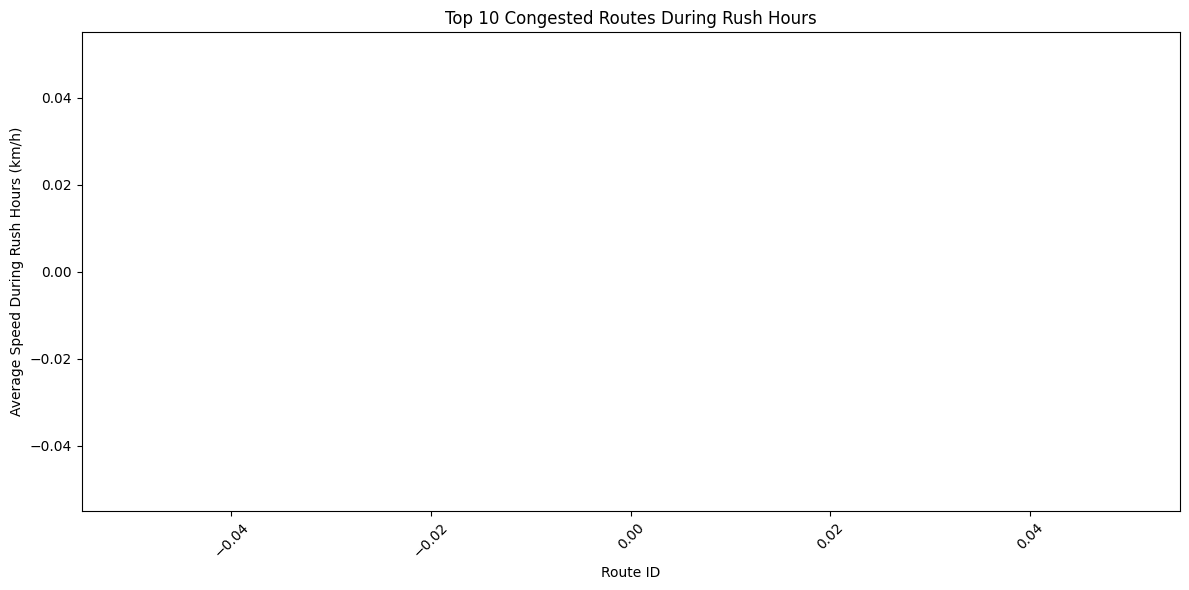

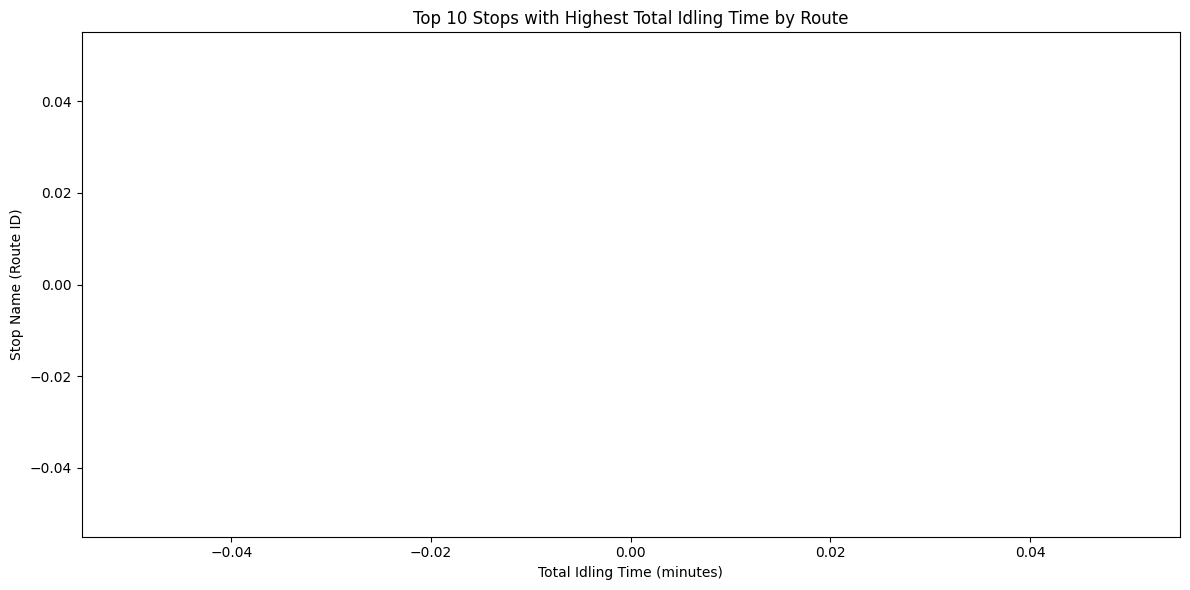

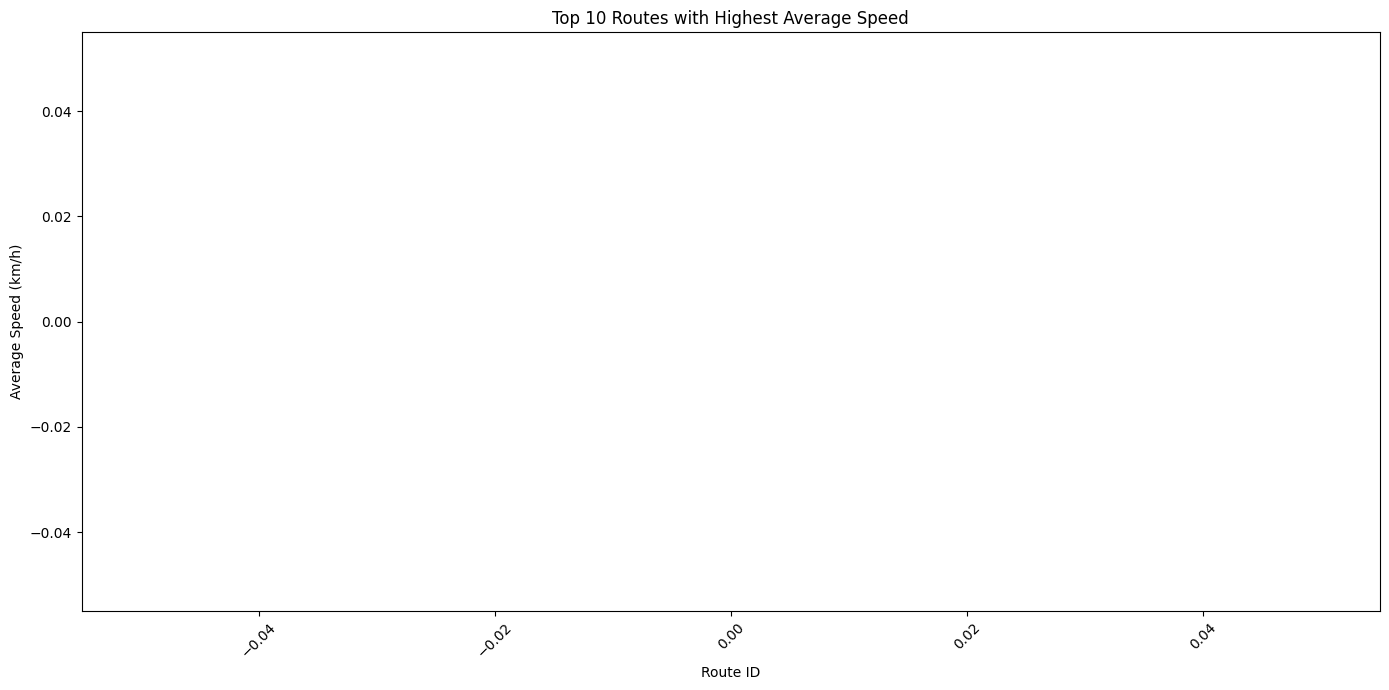

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x800 with 0 Axes>

In [181]:
# Display route analysis
print(route_analysis)

# Plot congested routes during rush hours
congested_routes = rush_hour_analysis.nsmallest(10, 'speed_kmph')
plt.figure(figsize=(12, 6))
plt.bar(congested_routes.index, congested_routes['speed_kmph'], color='red')
plt.title('Top 10 Congested Routes During Rush Hours')
plt.xlabel('Route ID')
plt.ylabel('Average Speed During Rush Hours (km/h)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot top idling stops by route
plt.figure(figsize=(12, 6))
plt.barh(top_idling_stops_routes['stop_name'] + ' (Route ' + top_idling_stops_routes['route_id'].astype(str) + ')',
         top_idling_stops_routes['idling_time'], color='orange')
plt.title('Top 10 Stops with Highest Total Idling Time by Route')
plt.xlabel('Total Idling Time (minutes)')
plt.ylabel('Stop Name (Route ID)')
plt.tight_layout()
plt.show()

# Plot top routes by average speed
top_10_routes = route_analysis.nlargest(10, 'speed_kmph')
plt.figure(figsize=(14, 7))
bars_speed = plt.bar(top_10_routes.index, top_10_routes['speed_kmph'], color='blue')
plt.title('Top 10 Routes with Highest Average Speed')
plt.xlabel('Route ID')
plt.ylabel('Average Speed (km/h)')
plt.xticks(rotation=45)
plt.tight_layout()
for bar in bars_speed:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, yval + 0.5, round(yval, 2), va='bottom')  # Add the labels
plt.show()

# Heatmap of idling times by stop and route
pivot_table = top_idling_stops_routes.pivot_table(values='idling_time', index='stop_name', columns='route_id', aggfunc='sum')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=.5, linecolor='gray')
plt.title('Heatmap of Top 10 Stops with Highest Total Idling Time by Route')
plt.xlabel('Route ID')
plt.ylabel('Stop Name')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Step 11: Headway Consistency
* **Metric**: Variability in the time between buses on the same route.
* **Insight**: Consistent headways are crucial for maintaining reliable
service, especially important when transitioning to electric buses
which may have different operational characteristics.

### Data Preparation

In [ ]:
# Configure logging to capture parsing errors
logging.basicConfig(filename='parse_time_errors.log', level=logging.ERROR)

# Load data
stops = gtfs_data['stops.txt']
routes = gtfs_data['routes.txt']
trips = gtfs_data['trips.txt']
stop_times = gtfs_data['stop_times.txt']

trips['route_id'] = trips['route_id'].astype(str).str.rstrip('.0')
routes['route_id'] = routes['route_id'].astype(str).str.rstrip('.0')

# Now perform the merge
stops_with_trips = stop_times.merge(trips[['trip_id', 'route_id']], on='trip_id', how='left') \
    .merge(routes[['route_id', 'route_short_name', 'route_long_name']], on='route_id', how='left') \
    .merge(stops[['stop_id', 'stop_code']], on='stop_id', how='left')


# Select relevant columns
stops_with_routes = stops_with_trips[['route_id', 'route_short_name', 'route_long_name', 'trip_id', 'stop_code',
                                      'stop_sequence', 'arrival_time', 'departure_time']]

# Function to parse time strings
def parse_time(time_str):
    if pd.isna(time_str):
        return None
    try:
        time_str = str(time_str)
        hours, minutes, seconds = map(int, time_str.split(':'))
        if hours >= 24:
            hours -= 24
        return f"{hours:02}:{minutes:02}:{seconds:02}"
    except ValueError as e:
        logging.error(f"Error parsing time '{time_str}': {e}")
        return None

# Apply the parse_time function and convert to datetime
for time_col in ['arrival_time', 'departure_time']:
    stops_with_routes[time_col] = stops_with_routes[time_col].apply(parse_time)
    stops_with_routes[time_col] = pd.to_datetime(stops_with_routes[time_col], format='%H:%M:%S', errors='coerce')

# Sort data by route, stop code, and arrival time
stops_with_routes = stops_with_routes.sort_values(by=['route_id', 'stop_code', 'arrival_time']).reset_index(drop=True)

# Calculate headway interval in minutes
stops_with_routes['headway_interval'] = stops_with_routes.groupby(['route_id', 'stop_code'])['arrival_time'].diff().dt.total_seconds() / 60

# Compute statistics for headway intervals
headway_stats = stops_with_routes.dropna(subset=['headway_interval']).groupby(['route_id', 'stop_code']).agg(
    mean_headway=('headway_interval', 'mean'),
    std_dev_headway=('headway_interval', 'std'),
    percentile_95_headway=('headway_interval', lambda x: x.quantile(0.95)),
    earliest_arrival=('arrival_time', 'min'),
    latest_departure=('departure_time', 'max')
).reset_index()

# Calculate minimum stop sequence and merge with stats
stop_sequence_min = stops_with_routes.groupby(['route_id', 'stop_code'])['stop_sequence'].min().reset_index()
headway_stats = headway_stats.merge(stop_sequence_min[['route_id', 'stop_code', 'stop_sequence']], on=['route_id', 'stop_code'], how='left')

# Format time columns for display
headway_stats['earliest_arrival'] = headway_stats['earliest_arrival'].dt.strftime('%H:%M:%S')
headway_stats['latest_departure'] = headway_stats['latest_departure'].dt.strftime('%H:%M:%S')

# Filter for bus routes (route_type == 3)
headway_stats = headway_stats.merge(routes[['route_id', 'route_short_name', 'route_long_name', 'route_type']], on='route_id', how='left')
headway_stats = headway_stats[headway_stats['route_type'] == 3]

# Function to convert minutes to HH:MM:SS format
def convert_to_hms(minutes):
    if pd.isna(minutes):
        return '00:00:00'
    total_seconds = minutes * 60
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

# Convert mean and std_dev headways to HH:MM:SS
headway_stats['mean_headway'] = headway_stats['mean_headway'].apply(convert_to_hms)
headway_stats['std_dev_headway'] = headway_stats['std_dev_headway'].apply(convert_to_hms)

# Save prepared DataFrames to CSV files
csv_path_headway = 'headway_stats.csv'
headway_stats.to_csv(csv_path_headway, index=False)

### Outputs and Visualizations

In [ ]:
# Initialize Panel extension for Jupyter
pn.extension()

# Load the CSV file
headway_stats = pd.read_csv('headway_stats.csv')

# Drop the 'route_type' column
headway_stats = headway_stats.drop(columns=['route_type'])

# Remove commas from 'route_id' and 'stop_code' columns
headway_stats['route_id'] = headway_stats['route_id'].astype(str).str.replace(',', '', regex=False)

# Remove '.0' from 'stop_code' by converting to int and then back to str
headway_stats['stop_code'] = headway_stats['stop_code'].astype(float).astype('Int64').astype(str)

# Format 'percentile_95_headway' column to 2 decimal places
headway_stats['percentile_95_headway'] = headway_stats['percentile_95_headway'].round(2)

# Convert the pandas DataFrame to a datatable frame
datatable_frame = dt.Frame(headway_stats)

# Convert the datatable frame back to a pandas DataFrame for Panel
headway_stats_for_panel = datatable_frame.to_pandas()

# Create a Panel interactive table
interactive_table = pn.widgets.DataFrame(headway_stats_for_panel, width=1500, height=400)

# Create separate search bar widgets (TextInput) for route_short_name, route_long_name, stop_code, route_id
route_short_name_search = pn.widgets.TextInput(placeholder='Search route_short_name', width=200)
route_long_name_search = pn.widgets.TextInput(placeholder='Search route_long_name', width=200)
stop_code_search = pn.widgets.TextInput(placeholder='Search stop_code', width=200)
route_id_search = pn.widgets.TextInput(placeholder='Search route_id', width=200)

# Create a button widget for triggering the search
search_button = pn.widgets.Button(name='Search', button_type='primary', width=100)

# Create a button widget for clearing the search
clear_button = pn.widgets.Button(name='Clear Search', button_type='default', width=100)

# Define a function to perform the search and update the table
def search_table(event):
    search_route_short_name = route_short_name_search.value.lower()
    search_route_long_name = route_long_name_search.value.lower()
    search_stop_code = stop_code_search.value.lower()
    search_route_id = route_id_search.value.lower()

    # Filter data based on the values entered in the search bars
    filtered_data = headway_stats_for_panel[
        headway_stats_for_panel['route_short_name'].str.contains(search_route_short_name, case=False, na=False) &
        headway_stats_for_panel['route_long_name'].str.contains(search_route_long_name, case=False, na=False) &
        headway_stats_for_panel['stop_code'].str.contains(search_stop_code, case=False, na=False) &
        headway_stats_for_panel['route_id'].str.contains(search_route_id, case=False, na=False)
    ]

    # Ensure filtered_data is a pandas DataFrame
    filtered_data = pd.DataFrame(filtered_data)

    # Recreate the interactive table with filtered data
    new_interactive_table = pn.widgets.DataFrame(filtered_data, width=1500, height=400)

    # Update the layout with the new table
    layout[1] = new_interactive_table  # Replace the existing table in the layout

# Define a function to clear the search fields
def clear_search(event):
    # Reset the text input fields
    route_short_name_search.value = ''
    route_long_name_search.value = ''
    stop_code_search.value = ''
    route_id_search.value = ''

    # Reset the table to the original data
    new_interactive_table = pn.widgets.DataFrame(headway_stats_for_panel, width=1500, height=400)

    # Update the layout with the original table
    layout[1] = new_interactive_table  # Replace the existing table in the layout

# Link the search button to the search function
search_button.on_click(search_table)

# Link the clear button to the clear search function
clear_button.on_click(clear_search)

# Layout the search bars, search button, and clear button in one row
search_row = pn.Row(
    route_short_name_search,
    route_long_name_search,
    stop_code_search,
    route_id_search,
    search_button,
    clear_button  # Add the clear button here
)

# Layout the complete UI with search row and the interactive table
layout = pn.Column(
    search_row,
    interactive_table
)

# Display the layout directly in Jupyter Notebook
layout
